In [2]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import skew
import math
import pandas as pd
import datetime
import yfinance as yf

In [3]:
def risk_contribution(weights, cov_matrix):
    portfolio_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    marginal_risk = np.dot(cov_matrix, weights) / portfolio_vol
    risk_contrib = np.multiply(weights, marginal_risk)
    return risk_contrib

def risk_parity_objective(weights, cov_matrix):
    risk_contribs = risk_contribution(weights, cov_matrix)
    target_risk = np.mean(risk_contribs)
    sum_sq_diff = sum([(rc - target_risk)**2 for rc in risk_contribs])
    return sum_sq_diff

def erc_portfolio(returns, initial_weights=None):
    """
    Build ERC portfolio from asset returns

    Parameters:
    returns: DataFrame of asset returns
    initial_weights: Initial guess for optimization (default: equal weights)

    Returns:
    optimal weights array
    """
    # Calculate covariance matrix
    cov_matrix = np.cov(returns.T)
    n_assets = len(returns.columns)

    if initial_weights is None:
        initial_weights = np.array([1/n_assets] * n_assets)

    # Constraints
    constraints = [
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # weights sum to 1
    ]

    # Bounds for weights (0 to 1)
    bounds = tuple((0, 1) for _ in range(n_assets))

    # Optimize
    result = minimize(risk_parity_objective,
                     initial_weights,
                     args=(cov_matrix,),
                     method='SLSQP',
                     constraints=constraints,
                     bounds=bounds,
                     tol=1e-12)

    return result.x

In [4]:
def calculate_start_dates(firstTrade):
  return datetime.datetime.strptime(firstTrade, '%Y-%m-%d') - datetime.timedelta(days=365)

def close_prices(ticker, startdate, enddate):
  df = yf.download(ticker, startdate, enddate)
  return df['Adj Close'].pct_change().values

In [5]:
tickers = ['PLTR', 'TSLA', 'INOD']

df = {}

for ticker in tickers:
  firstTrade = datetime.datetime.now().strftime("%Y-%m-%d")
  enddate = calculate_start_dates(firstTrade)
  df[ticker] = close_prices(ticker, enddate, firstTrade)
  print(ticker, len(df[ticker]))

# df['ETH-USD'] = df['ETH-USD'][:-251:-1]
df = pd.DataFrame(df)
df = df.dropna(axis=0)

np.cov(df.T)

[*********************100%%**********************]  1 of 1 completed


PLTR 251


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

TSLA 251
INOD 251


array([[0.0015811 , 0.00048024, 0.00072388],
       [0.00048024, 0.00147727, 0.00060947],
       [0.00072388, 0.00060947, 0.00643308]])

In [6]:
# Calculate ERC weights expected individual daily volatility is {},
weights = erc_portfolio(df)

def calculate_sharpe_ratio(ticker, end_date):
  start_date = calculate_start_dates(end_date)
  df = yf.download(ticker, start=start_date, end=end_date)
  df = df['Adj Close'].pct_change().dropna(axis=0)
  return (df.mean() - 0.0253 / 256) / df.std() * math.sqrt(256)

# Print results
for asset, weight in zip(df.columns, weights):
    print(f"{asset}: optimal weight should be {weight:.2%}, expected sharpe ratio is {calculate_sharpe_ratio(asset, datetime.datetime.today().strftime('%Y-%m-%d'))}")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

PLTR: optimal weight should be 38.90%, expected sharpe ratio is 2.031606265378583
TSLA: optimal weight should be 40.80%, expected sharpe ratio is 0.798966035202282
INOD: optimal weight should be 20.30%, expected sharpe ratio is 1.8426057855360185


In [7]:
weights = [0.38, 0.09, 0.19]

# Total Risk Calculator
def calculate_portfolio_volatility(weights, covariance_matrix):
    # Calculate the variance of the portfolio
    variance = np.dot(weights, np.dot(covariance_matrix, weights))

    # Return the standard deviation (volatility) of the portfolio
    return np.sqrt(variance)

covariance_matrix = np.cov(df.T)
print(covariance_matrix)

# Calculate and print the portfolio volatility
portfolio_volatility = calculate_portfolio_volatility(weights, covariance_matrix)
print(f"The portfolio volatility is: {portfolio_volatility:.2%}")

[[0.0015811  0.00048024 0.00072388]
 [0.00048024 0.00147727 0.00060947]
 [0.00072388 0.00060947 0.00643308]]
The portfolio volatility is: 2.51%


[Text(0.5, 1.0, 'Frequency Histogram'), Text(0, 0.5, 'Frequency')]

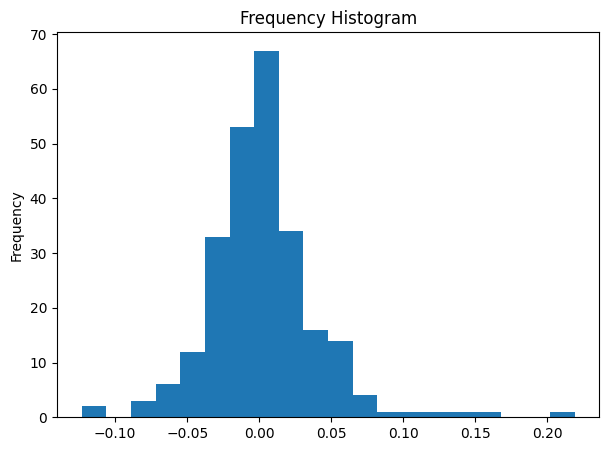

In [12]:
# Frequency Distribution
from matplotlib import pyplot as plt
%matplotlib inline

plt.rcParams.update({'figure.figsize': (7, 5), 'figure.dpi': 100})

x = df['TSLA']
plt.hist(x, bins=20)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency')